In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Specifications

In [2]:
save = True
var = 'returnPeriod_MSWEP_1d'

# Load County Level Demographics

In [3]:
# Load demographics
county_demo = pd.read_csv('County_Demographics/county_demographics.csv')

# Load and Filter Claims

In [4]:
claims = pd.read_csv("../Low_Return_Period/no_percentile_filter/final_filtered_claims.csv")
# Create new field for 'totalClaimPaid'
claims['totalClaimPaid'] = claims['amountPaidOnBuildingClaim']+claims['amountPaidOnContentsClaim']
# Filter stateOwnedIndicator is True
claims = claims[claims['stateOwnedIndicator'] != True]
# Create mitigated field
claims['mitigated'] = claims['elevatedBuildingIndicator'] | claims['floodproofedIndicator']
# merge sociodemographics on 'countyCode' using a left join to keep all rows in nfip_losses
claims = claims.merge(county_demo, left_on='countyCode', right_on='FIPS', how='left')
# Filter the dataframe where buildingDamageAmount is more than $1000
claims = claims[claims['buildingDamageAmount'] > 1000]

/tmp/ipykernel_2752/2504036271.py:1: DtypeWarning: Columns (8,33,36,39,43,52,53,62) have mixed types. Specify dtype option on import or set low_memory=False.
  claims = pd.read_csv("../Low_Return_Period/no_percentile_filter/final_filtered_claims.csv")


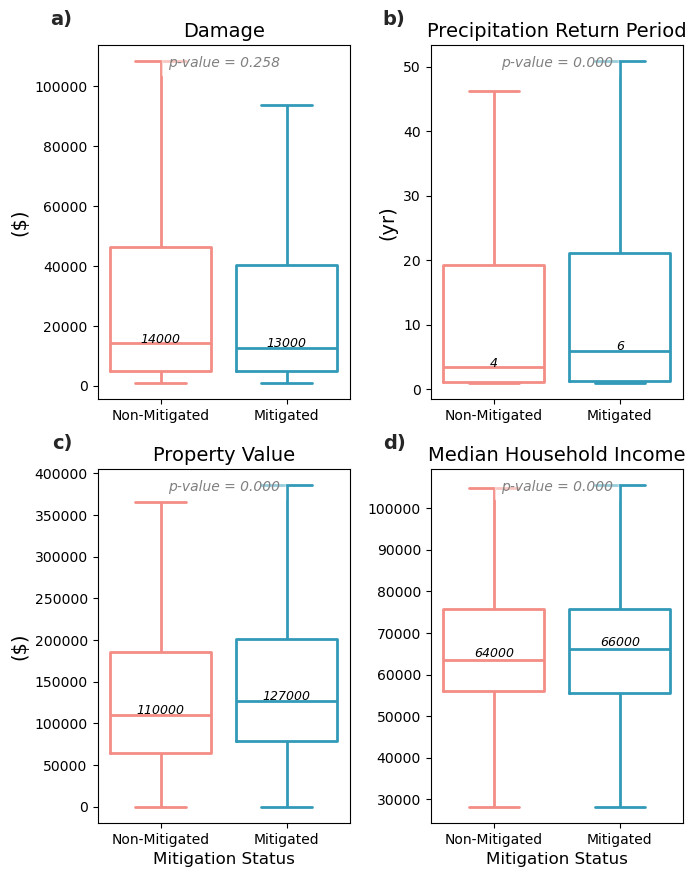

In [5]:
# Set the specific color palette for mitigated and non-mitigated
custom_palette = {'Mitigated': '#329AB8', 'Non-Mitigated': '#f38d85'}

# Mapping the binary 'mitigated' column to more descriptive labels
claims['Mitigated_Status'] = claims['mitigated'].map({1: 'Mitigated', 0: 'Non-Mitigated'})

# Define the mapping for y-axis labels and titles
label_map = {
    'buildingDamageAmount': 'Damage',
    var: 'Precipitation Return Period',
    'buildingPropertyValue': 'Property Value',
    'Median_Household_Income_2021': 'Median Household Income'
}

# Clip the lower bounds at 0
for column in label_map.keys():
    claims[column] = claims[column].clip(lower=0)

# Create a 2x2 grid for the plots with adjusted figsize
fig, axes = plt.subplots(2, 2, figsize=(7.09, 7.09*15/12))  # 7.09 inches is approximately 180mm
axes = axes.flatten()

columns = ['buildingDamageAmount', var, 'buildingPropertyValue', 'Median_Household_Income_2021']

for i, column in enumerate(columns):
    # Split the data based on 'Mitigated_Status'
    data1 = claims[claims['Mitigated_Status'] == 'Mitigated'][column].dropna()
    data2 = claims[claims['Mitigated_Status'] == 'Non-Mitigated'][column].dropna()

    # Perform a two-tailed t-test
    t_stat, p_value = ttest_ind(data1, data2, equal_var=False)

    sns.set_theme(style="ticks")
    
    # Create the boxplot with no fliers and custom colors
    sns.boxplot(
        x='Mitigated_Status', 
        y=column, 
        data=claims, 
        ax=axes[i], 
        showfliers=False,
        hue='Mitigated_Status',
        palette=custom_palette,
        fill=False,
        linewidth=2,  # Adjust the thickness of the borders
    )
    
    # Label the median values on the plot, rounded to the nearest 1000
    median_data = claims.groupby('Mitigated_Status')[column].median()
    for tick, label in zip(axes[i].get_xticks(), axes[i].get_xticklabels()):
        if column == var:
            axes[i].text(
                tick, median_data[label.get_text()]*1.01, 
                f'{median_data[label.get_text()]:.0f}', 
                horizontalalignment='center', color='black', style='italic',fontsize=9
            )
        else:
            axes[i].text(
                tick, median_data[label.get_text()]*1.01, 
                f'{median_data[label.get_text()].round(-3):.0f}', 
                horizontalalignment='center', color='black', style='italic',fontsize=9
            )
    
    # Display the p-value on the plot, italicized and font size 10
    axes[i].text(0.5, 0.95, f'p-value = {p_value:.3f}', 
                 ha='center', va='center', transform=axes[i].transAxes,
                 fontsize=10, style='italic', color='grey', bbox=dict(facecolor='white', alpha=0.5))
    
    # Set title with larger fonts
    axes[i].set_title(f'{label_map[column]}', fontsize=14)
    
    # Remove x labels for top two plots
    if i < 2:
        axes[i].set_xlabel('')
    else:
        axes[i].set_xlabel('Mitigation Status', fontsize=12)

    # Remove y labels for right two plots
    if (i == 0 or i == 2):
        axes[i].set_ylabel('($)', fontsize=14)
    else:
        if column == var:
            axes[i].set_ylabel('(yr)', fontsize=14)
        else:
            axes[i].set_ylabel('')

# Add subplot labels (a), (b), (c), (d)
subplot_labels = ['a)', 'b)', 'c)', 'd)']
for ax, label in zip(axes, subplot_labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=14, weight='bold', va='top', ha='right')

# Adjust layout for more space between plots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Adjust layout to ensure tight fit
plt.tight_layout()

# Save the plot with 500 dpi
if save:
    output_path = 'Plots/SI/F2_Mitigated_Comparison.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')

plt.show()